In [ ]:

from IPython import get_ipython
from IPython.display import display

import kagglehub
# Download the dataset and get the path to the downloaded files
usefashrfi_iran_used_cars_dataset_path = kagglehub.dataset_download('usefashrfi/iran-used-cars-dataset')

print('Data source import complete.')
# Print the downloaded path to verify
print(f'Downloaded data path: {usefashrfi_iran_used_cars_dataset_path}')



Data source import complete.
Downloaded data path: /kaggle/input/iran-used-cars-dataset


# Used Car Classify skresnet34

In [ ]:
!pip install timm

In [ ]:
#import needed library and package
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define a sequence of image transformations and normalize images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set Dataset and Dataloader

In [ ]:
# Get a sorted list of class names from the training dataset directory.
class_names=sorted(os.listdir('/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/train'))
print(class_names)
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))

['Mazda-2000', 'Nissan-Zamiad', 'Peugeot-206', 'Peugeot-207i', 'Peugeot-405', 'Peugeot-Pars', 'Peykan', 'Pride-111', 'Pride-131', 'Quik', 'Renault-L90', 'Samand', 'Tiba2']
13


In [ ]:
# Create a list to store paths and labels for the training set.
path_label=[]
for dirname, _, filenames in os.walk('/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            path_label+=[(path,normal_mapping[label])]

# Create a list to store paths and labels for the validation set.
vpath_label=[]
for dirname, _, filenames in os.walk('/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/val'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            vpath_label+=[(path,normal_mapping[label])]

# Create a list to store paths and labels for the test set.
tpath_label=[]
for dirname, _, filenames in os.walk('/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/test'):
    for filename in filenames:
        if filename[-4:]=='.jpg':#check if the file is JPG
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            tpath_label+=[(path,normal_mapping[label])]



In [ ]:
# Define a custom Dataset class for loading images.
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label # Initialize the dataset with a list of image paths and labels
        self.transform = transform # Initialize the transformation to be applied to images.

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]  # Get the image path and label for a given index.
        img = Image.open(path).convert('RGB') # Open the image and convert it to RGB format.

        if self.transform is not None:  # Apply the transformation if it is provided.
            img = self.transform(img)

        return img, label # Return the transformed image and its label.

In [ ]:
# Create instances of the ImageDataset for training, validation, and testing.
trainset = ImageDataset(path_label, transform)
valset = ImageDataset(vpath_label, transform)
testset = ImageDataset(tpath_label, transform)

# Extract the labels from the training set.
labels = [label for _, label in trainset.path_label]

# Create DataLoader instances for the training, validation, and test sets.
train_loader=DataLoader(trainset,batch_size=32,shuffle=True)
val_loader=DataLoader(valset,batch_size=32)
test_loader=DataLoader(testset,batch_size=32)

In [ ]:
for images, labels in train_loader: # Get a batch of images and labels from the training loader.
    break
im=make_grid(images,nrow=16)

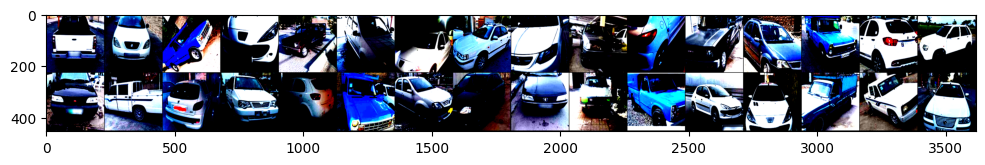

In [ ]:
# Display the image grid
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
# Define an inverse normalization transformation.
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

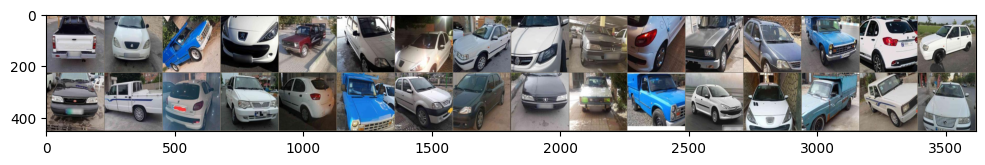

In [ ]:
plt.figure(figsize=(12,12)) # Apply inverse normalization to image grid
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Model:

In [ ]:
torch.manual_seed(42) # Set the random seed for PyTorch to ensure reproducibility.

In [ ]:
class MyModel(nn.Module): # Define a custom neural network model.

    def __init__(self, model_name='skresnet34', pretrained=True): # Initialize the model with a base model name and whether to use pretrained weights.
        super(MyModel, self).__init__() # Create the base model using timm.
        self.model = timm.create_model(model_name, pretrained, in_chans=3)
        self.fc1 = nn.Linear(1000,16)  # Add fully connected layers for classification.
        self.fc2 = nn.Linear(16,64)
        self.fc3 = nn.Linear(64,len(class_names))

    def forward(self, x):  # Define the forward pass of the model.
        #print(x.shape)
        x = self.model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        #print(x.shape)
        return x

model = MyModel() # Create an instance of the custom model.

In [ ]:
criterion=nn.CrossEntropyLoss() # Define the loss function (Cross-Entropy Loss) for classification.
optimizer=torch.optim.Adam(model.parameters(),lr=0.001) # Define the optimizer (Adam) for updating model weights.

In [ ]:
epochs=3

import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs): # Start the training loop.
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader): # Iterate through the training data loader.
        b+=1
        y_pred=model(X_train)    # Get predictions from the model.
        loss=criterion(y_pred,y_train)
        predicted=torch.max(y_pred.data,1)[1] # Get the predicted class
        batch_corr=(predicted==y_train).sum()   # Calculate the number of correct predictions in the batch.
        trn_corr+= batch_corr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad(): # Start evaluation phase
        for b, (X_test,y_test) in enumerate(val_loader):
            b+=1
            y_val=model(X_test) # Get predictions from the model.
            predicted=torch.max(y_val.data,1)[1] # Get predicted class
            btach_corr=(predicted==y_test).sum() # Calculate the number of correct predictions in the batch
            tst_corr+=btach_corr

    loss=criterion(y_val,y_test) # Calculate the loss on the last batch of the validation set.
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  200 [  2000/8000]  loss: 0.95651925  accuracy: 209.750%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.58937240  accuracy: 283.600%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.07277244  accuracy: 296.350%

Duration: 6641 seconds


# Predict

In [ ]:
device = torch.device("cpu")   #"cuda:0"

model.eval() # Set the model to evaluation mode.
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader: # Iterate through the test data loader.
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)  # Get predictions from the model and find the predicted class index.
        for i in range(len(pred)):  # Append true and predicted labels to their respective lists
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(y_true[0:5])
print(y_pred[0:5])

[8, 8, 8, 8, 8]
[7, 8, 7, 7, 8]


In [ ]:
# Print the classification report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

               precision    recall  f1-score   support

   Mazda-2000     0.9595    0.7717    0.8554        92
Nissan-Zamiad     1.0000    0.7978    0.8875        89
  Peugeot-206     0.9279    0.8655    0.8957       119
 Peugeot-207i     0.5094    0.2411    0.3273       112
  Peugeot-405     0.9104    0.6854    0.7821        89
 Peugeot-Pars     0.8403    0.8929    0.8658       112
       Peykan     0.4846    0.9565    0.6433       115
    Pride-111     0.6176    0.9692    0.7545       130
    Pride-131     0.3981    0.3628    0.3796       113
         Quik     0.9562    0.8618    0.9066       152
  Renault-L90     0.7500    0.3980    0.5200        98
       Samand     0.8705    0.9528    0.9098       127
        Tiba2     0.9829    0.9127    0.9465       126

     accuracy                         0.7571      1474
    macro avg     0.7852    0.7437    0.7441      1474
 weighted avg     0.7830    0.7571    0.7503      1474



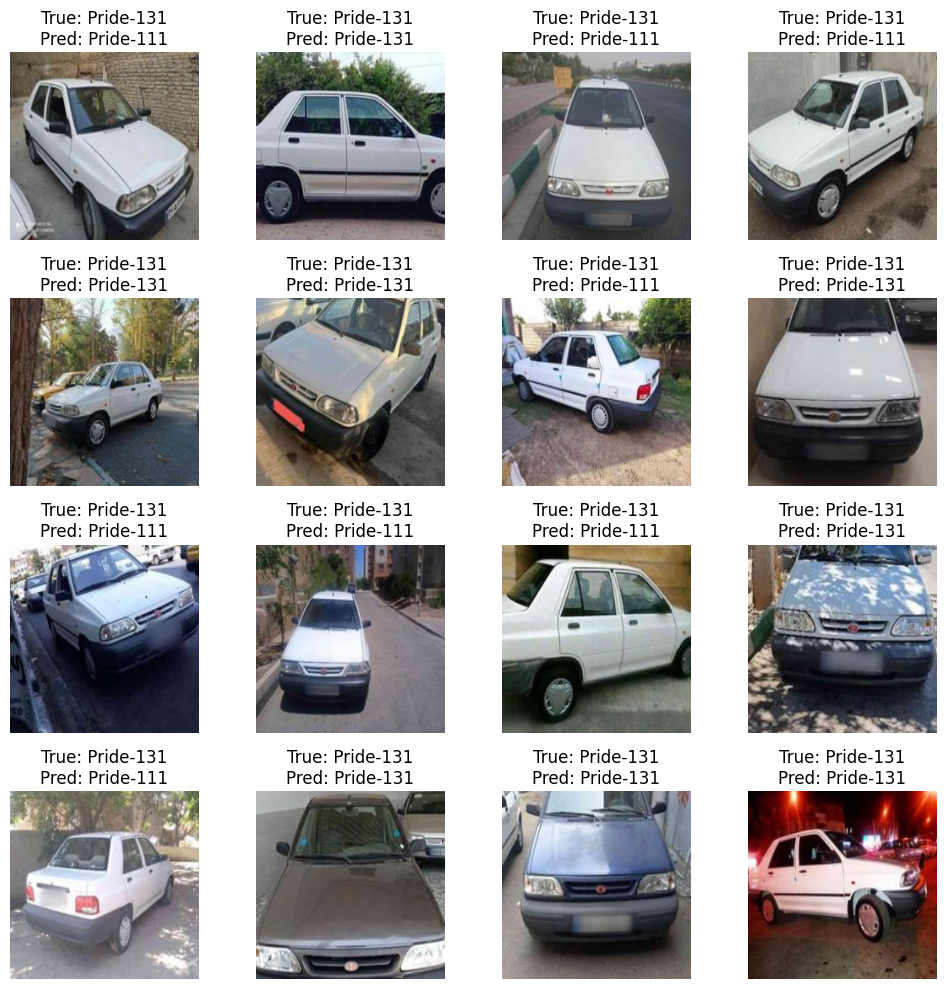

In [ ]:
# Display random prediction
import matplotlib.pyplot as plt
import numpy as np

rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Get a batch of test data
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(test_images)
    _, predicted = torch.max(outputs, 1)

# Denormalize the images for display
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    # Ensure the image is in the correct format for matplotlib (channels last)
    img = inv_normalize(test_images[i]).permute(1, 2, 0).numpy()
    # Clip values to be in [0, 1]
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    true_label = reverse_mapping[test_labels[i].item()]
    pred_label = reverse_mapping[predicted[i].item()]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

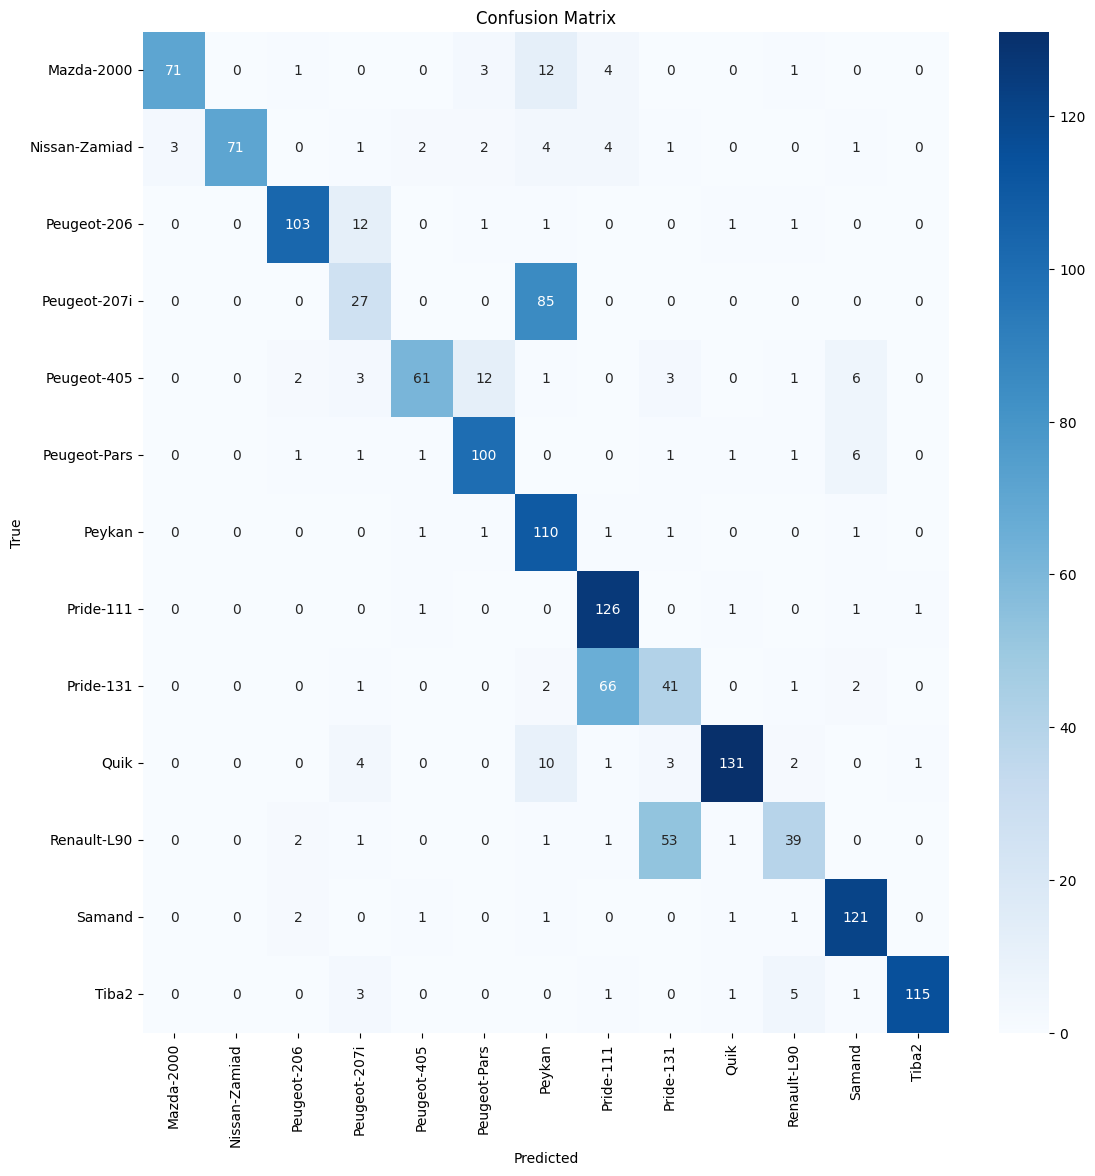

In [ ]:
#Display confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(len(class_names), len(class_names)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Display model accuracy
import numpy as np
print("\nAccuracy: {:.4f}".format(np.mean(np.array(y_true) == np.array(y_pred))))


Accuracy: 0.7571


In [ ]:
import numpy as np
accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
print(f"\nAccuracy on test dataset: {accuracy:.4f}%")


Accuracy on test dataset: 75.7123%


epoch limited to 3 in this project due to GPU deficiency. Set more epoch for improved accuracy.